# Database manipulation with pandas

You can use any database library to manipulate data in the ARIEL database. In this example we will be using pandas.

In [2]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

## 1. How to get data about the experiment

As explained above, ARIEL uses an SQL database to store the data for the individuals. This means that we have a complete file of every individual that existed during the evolution process whether they died or continued to live until the final generation.  

## 1.1 Database to pandas dataframe

All data about the individuals is stored in the `individual` table. The following line shows you how to turn the database into a pandas DataFrame, which then allows you to manipulate and use the data however you want.

In [3]:
data = pd.read_sql("SELECT * FROM individual", sqlite3.connect("__data__/database.db"))

In [4]:
data.head(5)

,id,alive,time_of_birth,time_of_death,requires_eval,fitness_,requires_init,genotype_,tags_
0,1,0,0,7,0,21.507857,0,"[54.5476194721131, 18.787697613687754, 87.9664...",{}
1,2,0,0,4,0,21.764198,0,"[-23.51735411458668, 83.29895497528028, -50.73...",{}
2,3,0,0,2,0,21.364822,0,"[-41.8642899864318, -26.625290981240703, 21.46...",{}
3,4,0,0,4,0,21.965413,0,"[-2.399348473982663, 32.83936881495799, 49.437...",{}
4,5,0,0,1,0,21.852740,0,"[40.97966824037182, -45.6694431228661, -49.292...",{}


### 2. Get population per generation

The way ARIEL keeps track of individuals is not in the form of a list for each generation like it is more usually used in EAs. Normally in EAs, the population is represented as a list holding the "current alive population". This means that if you want more detailed data on individuals that did not survive to the end of the evolution loop you do not have that data.

Since we have kept track of all individuals to ever exist in the experiment in the database, we can pull that data and use it to get statistics about the experiment. But, since we don't have the list of individuals per generation, we need to make it. 

We can do that using the `time_of_birth` and `time_of_death` values for each individual.

In [5]:
# Get minimum and maximum generation number
min_gen = int(data['time_of_birth'].min())
max_gen = int(data['time_of_death'].max())

# Get all individuals that are alive in each generation
population_per_gen = {
    gen: data.loc[(data['time_of_birth'] <= gen) & (data['time_of_death'] > gen), 'id'].tolist()
    for gen in range(min_gen, max_gen + 1)
}

# Structure dataframe for easier viewing
pop_df = pd.DataFrame({
    'generation': list(population_per_gen.keys()),
    'individuals': list(population_per_gen.values()),
    'pop size': [len(v) for v in population_per_gen.values()]
    })

pop_df.head(4)

,generation,individuals,pop size
0,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",100
1,1,"[1, 2, 3, 4, 7, 8, 9, 10, 12, 15, 20, 21, 22, ...",100
2,2,"[1, 2, 4, 7, 9, 10, 15, 21, 22, 25, 26, 32, 34...",100
3,3,"[1, 2, 4, 9, 10, 15, 21, 22, 25, 26, 32, 35, 3...",100


## 2. Computing fitness statistics per generation

Now that we know which individuals were alive in each generation, we can compute:
- Mean fitness
- Standard deviation
- Best (minimum) fitness

In [6]:
# Get the fitness of every individual
fitness_by_id = data.set_index('id')['fitness_']

# Initialise lists
means = []
stds = []
maxs = []

# Get data from dataframe
for gen in pop_df['generation']:
    ids = population_per_gen.get(int(gen), [])
    if not ids:
        means.append(np.nan)
        stds.append(np.nan)
        maxs.append(np.nan)
        continue

    fits = fitness_by_id.reindex(ids).dropna().astype(float).values

    # If there is no data, initialise it as nan to avoid erors
    if fits.size == 0:
        means.append(np.nan)
        stds.append(np.nan)
        maxs.append(np.nan)
    
    # If there is data, add it to the list
    else:
        means.append(float(np.mean(fits)))
        stds.append(float(np.std(fits, ddof=0)))
        maxs.append(float(np.min(fits)))

# Add data to separate columns
pop_df['fitness_mean'] = means
pop_df['fitness_std'] = stds
pop_df['fitness_best'] = maxs

# Show dataframe
pop_df.head(4)

,generation,individuals,pop size,fitness_mean,fitness_std,fitness_best
0,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",100,21.666660,0.273939,20.806873
1,1,"[1, 2, 3, 4, 7, 8, 9, 10, 12, 15, 20, 21, 22, ...",100,21.399773,0.664911,19.846392
2,2,"[1, 2, 4, 7, 9, 10, 15, 21, 22, 25, 26, 32, 34...",100,21.261569,0.748077,19.952315
3,3,"[1, 2, 4, 9, 10, 15, 21, 22, 25, 26, 32, 35, 3...",100,21.159823,0.801033,19.862954


## 3. Plotting

Now that we have the mean and best fitness and standard deviation per generation, we can use them to plot the fitness progression 

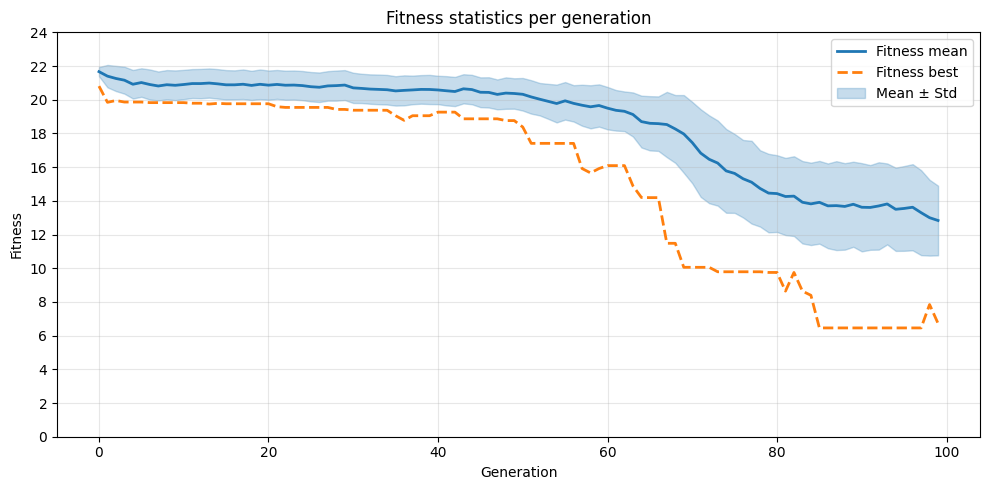

In [7]:
# Create a copy of dataframe
df = pop_df.copy()

# Create mask to avoid missing data 
# if the evolution process was done correctly this should not change anything.
# This mask could be used to get custom data out of the dataframe
mask = df['fitness_mean'].notna()

# Get data according to the mask
x = df.loc[mask, 'generation']
mean = df.loc[mask, 'fitness_mean']
std = df.loc[mask, 'fitness_std']
maxv = df.loc[mask, 'fitness_best']

# Generate line plot of fitness per generation
plt.figure(figsize=(10, 5))
plt.plot(x, mean, label='Fitness mean', color='C0', linewidth=2)
plt.plot(x, maxv, label='Fitness best', color='C1', linestyle='--', linewidth=2)
plt.fill_between(x, mean - std, mean + std, color='C0', alpha=0.25, label='Mean ± Std')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness statistics per generation')
plt.legend()
plt.grid(alpha=0.3)
plt.yticks(range(0, int(max(df["fitness_mean"]) + 5), 2))
plt.tight_layout()
plt.show()